In [7]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

## Q2

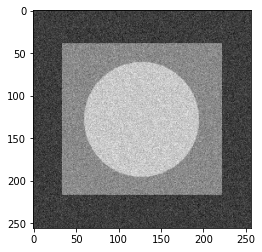

In [11]:
fig = cv2.imread("Fig1 (1).tif")
plt.imshow(fig, cmap = 'gray')

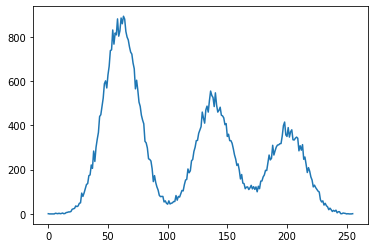

In [14]:
histr = cv2.calcHist([fig],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

It is clear from the histogram that the image has Gaussian noise.
The probability density function is:
$\frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{(z-\bar{z})^{2}}{2 \sigma^{2}}}-\infty<z<\infty$

(50, 50, 3)


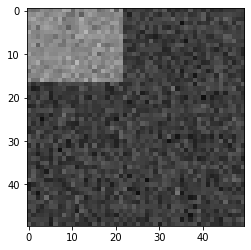

In [15]:
I_cropped = fig[200:250, 200:250]
print(I_cropped.shape)
plt.imshow(I_cropped, cmap = 'gray')

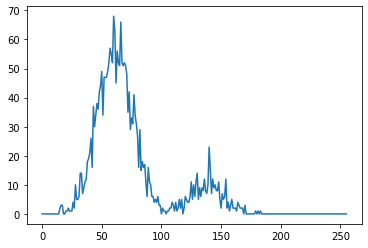

In [17]:
histr = cv2.calcHist([I_cropped],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

Here, $\frac{1}{\sqrt{2 \pi} \sigma}$ = 60 and mean is approximately 60

In [18]:
variance = (1/(math.sqrt(2*math.pi)*60))**2
variance

4.420970641441538e-05

Text(0.5, 1.0, 'harmonicmean  3*3 kernel')

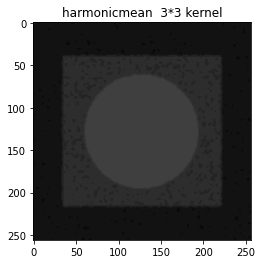

In [23]:
kernel = np.ones((3,3), np.float32)/9
box = cv2.filter2D(fig, -1, kernel)
rows, cols = box.shape[:2]
ksize = 3
padsize = int((ksize-1)/2)
pad_img = cv2.copyMakeBorder(box, *[padsize]*4, cv2.BORDER_DEFAULT)
harmonicmean = np.zeros_like(box)
for r in range(rows):
    for c in range(cols):
        harmonicmean[r, c] = 1/np.sum(1/pad_img[r:r+ksize, c:c+ksize])
harmonicmean = harmonicmean*ksize**2
plt.imshow(harmonicmean)
plt.title('harmonicmean  3*3 kernel')

## Q4

In [24]:
N = 2
histograms = np.array([[1,1,0,1,1,1,1,1,0],
                       [1,0,1,1,1,1,1,0,1],])

In [25]:
def compute_cost_matrices(histograms):
    
    cost_matrix_eucl  = np.zeros((N,N))
    cost_matrix_cos  = np.zeros((N,N))

    for row, hist_row in enumerate(histograms):
        for col, hist_col in enumerate(histograms):
            eucl_dist = np.linalg.norm(hist_row-hist_col)
            cost_matrix_eucl[row, col] = eucl_dist
            cos_sim = np.dot(hist_row, hist_col) / (np.linalg.norm(hist_row)* np.linalg.norm(hist_col))
            cost_matrix_cos[row, col] = cos_sim
    return cost_matrix_eucl, cost_matrix_cos

def plotCostMatrix(ax, cost_matrix, title):
    axh = ax.imshow(cost_matrix, cmap='viridis') 
    plt.colorbar(axh, ax = ax)
    ax.set_title(title)

cm_eucl, cm_cos = compute_cost_matrices(histograms)

In [39]:
## weighing tf-idf function
def reweight_tf_idf(histograms):
    re_hists  = np.zeros(histograms.shape)
    N = histograms.shape[0]
    n_i = np.sum(histograms > 0, axis=0)
    for hist_id in range(histograms.shape[0]):
        n_d  = np.sum(histograms[hist_id])
        for bin_id in range(len(histograms[hist_id])): 
            re_hists[hist_id, bin_id] = histograms[hist_id, bin_id]/ n_d * np.log(N/n_i[bin_id])
            #print(re_hists[hist_id, bin_id], histograms[hist_id, bin_id], n_d, N, n_i[bin_id])
    return re_hists

re_hists = reweight_tf_idf(histograms)
print(re_hists)

[[0.         0.09902103 0.         0.         0.         0.
  0.         0.09902103 0.        ]
 [0.         0.         0.09902103 0.         0.         0.
  0.         0.         0.09902103]]


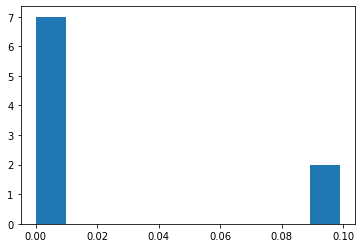

In [54]:
plt.hist(re_hists[1])
plt.show()

[[0.         0.19804205]
 [0.19804205 0.        ]]


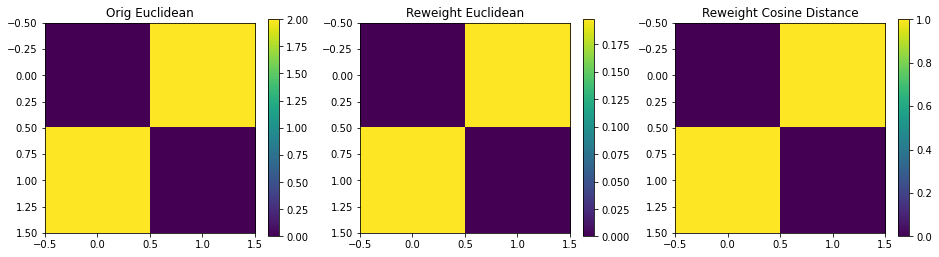

In [27]:
cm_eucl, cm_cos = compute_cost_matrices(histograms)
cm_eucl_w, cm_cos_w = compute_cost_matrices(re_hists)

print(cm_eucl_w)



fig, ax = plt.subplots(1,3, figsize=(16,4));

plotCostMatrix(ax[0], cm_eucl, "Orig Euclidean")
plotCostMatrix(ax[1], cm_eucl_w, "Reweight Euclidean")
plotCostMatrix(ax[2], 1- cm_cos_w, "Reweight Cosine Distance")

In [31]:
hist_norm = normToUnitLength(histograms)

squared Euclidean vs adapted cosine difference
[[4.44089210e-16 1.11022302e-16]
 [1.11022302e-16 4.44089210e-16]]


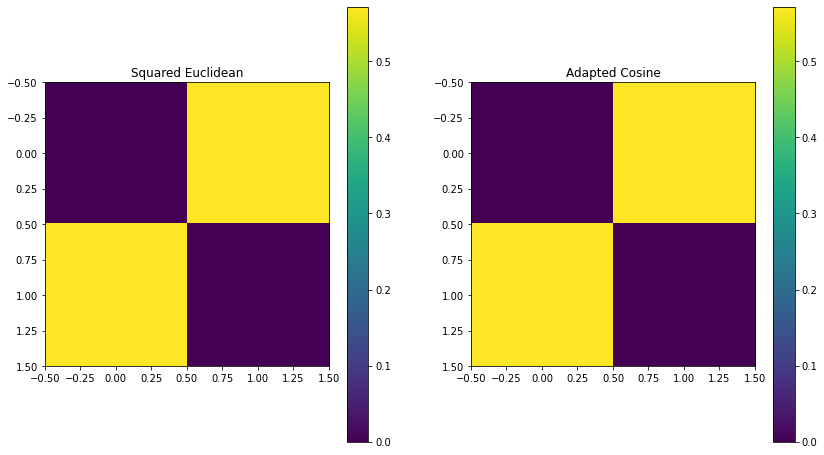

In [34]:
cm_eucl, cm_cos = compute_cost_matrices(histograms)
cm_eucl_norm, cm_cos_norm = compute_cost_matrices(hist_norm)
cm_eucl_w, cm_cos_w = compute_cost_matrices(re_hists)

print("squared Euclidean vs adapted cosine difference")
print(np.fabs(cm_eucl_norm**2 - (2 - 2*cm_cos_norm)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))

plotCostMatrix(ax1, cm_eucl_norm**2, "Squared Euclidean")
plotCostMatrix(ax2, 2 - 2*cm_cos_norm, "Adapted Cosine")

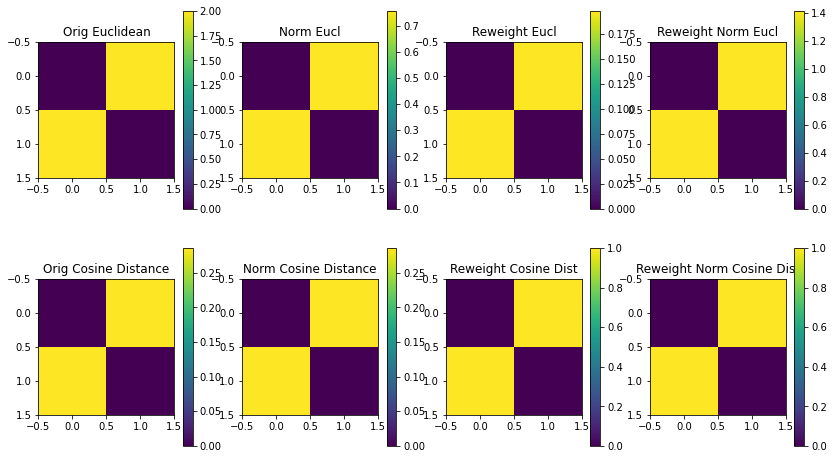

In [36]:
# normalizing reweighted histograms
hist_weigh_norm = normToUnitLength(re_hists)
cm_eucl_w_norm, cm_cos_w_norm = compute_cost_matrices(hist_weigh_norm)

fig, axs = plt.subplots(2, 4, figsize=(14,8))

plotCostMatrix(axs[0][0], cm_eucl, "Orig Euclidean")
plotCostMatrix(axs[1][0], 1 - cm_cos, "Orig Cosine Distance")

plotCostMatrix(axs[0][1], cm_eucl_norm, "Norm Eucl")
plotCostMatrix(axs[1][1], 1 - cm_cos_norm, "Norm Cosine Distance")

plotCostMatrix(axs[0][2], cm_eucl_w, "Reweight Eucl")
plotCostMatrix(axs[1][2], 1 - cm_cos_w, "Reweight Cosine Dist")

plotCostMatrix(axs[0][3], cm_eucl_w_norm, "Reweight Norm Eucl")
plotCostMatrix(axs[1][3], 1 - cm_cos_w_norm, "Reweight Norm Cosine Dist")

## Q3

In [64]:
from numpy.lib.stride_tricks import as_strided


def pool2d(A, kernel_size, stride, padding, pool_mode='max'):

    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
    A_w = as_strided(A, shape_w, strides_w)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))

In [63]:
   '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window over which we take pool
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''

"\n 2D Pooling\n\n Parameters:\n     A: input 2D array\n     kernel_size: int, the size of the window over which we take pool\n     stride: int, the stride of the window\n     padding: int, implicit zero paddings on both sides of the input\n     pool_mode: string, 'max' or 'avg'\n "

In [65]:
A = [[255,40,103,134],
    [95,39,56,67],
    [48,28,39,51],
    [24,12,17,21]]

In [68]:
# i)
pool2d(A, 2, 1, 0, "max")

array([[255, 103, 134],
       [ 95,  56,  67],
       [ 48,  39,  51]])

In [69]:
# ii)
pool2d(A, 2, 2, 0, "avg")

array([[107.25,  90.  ],
       [ 28.  ,  32.  ]])